# Stats Generator

This notebook is used to calculate player statistics for IPL/IT20 games across a customizable time period.

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

sns.set_style("whitegrid")
color_pal = sns.color_palette("Set1")

In [2]:
# Reading in the ball by ball data

bbb = pd.read_csv('ball_by_ball_it20.csv')
#bbb = pd.read_csv('ball_by_ball_ipl.csv')

# Convert the date column to datetime YYYY-MM-DD
bbb['Date'] = pd.to_datetime(bbb['Date'], format=r'%Y-%m-%d')

# Specify the data range we want to analyze
start_date, end_date = bbb['Date'].min(), '2023-12-18'

# convert start_data to string
start_date = start_date.strftime('%Y-%m-%d')
start_date = '2021-12-18'
date_range = pd.date_range(start_date, end_date)

# Filter the data for the specified date range
bbb = bbb[bbb['Date'].isin(date_range)]

bbb['Date'].describe()

count                           144739
mean     2022-10-29 22:30:08.469037056
min                2021-12-22 00:00:00
25%                2022-07-10 00:00:00
50%                2022-10-05 00:00:00
75%                2023-03-02 00:00:00
max                2023-08-22 00:00:00
Name: Date, dtype: object

In [3]:
batters = set(bbb[['Batter', 'Non Striker']].values.flatten().tolist())
bowlers = bbb['Bowler'].unique()
players = set(batters).union(set(bowlers))

print(f'Number of unique batters: {len(batters)}')
print(f'Number of unique bowlers: {len(bowlers)}')
print(f'Number of unique players: {len(players)}')

Number of unique batters: 1672
Number of unique bowlers: 1201
Number of unique players: 1774


In [4]:
cols = ['player',  'runs', 'balls', '4s', '6s', 'batting SR', 'batting average', 'times dismissed', 'balls bowled', 'runs conceded', 'wickets', 'economy', 'bowling average', 'bowling SR', 'overs bowled', 'wides', 'noballs']
stats = pd.DataFrame(columns=cols) # This is where we will store the player stats

# Initialize stats for each player
for player in players:

    player_stats = pd.Series()
    player_stats['player'] = player

    # Initialize other stats to 0
    for col in cols[1:]:
        player_stats[col] = 0

    # Add the player to the stats dataframe
    stats.loc[len(stats)] = player_stats

stats.set_index('player', inplace=True)

stats.head()

,runs,balls,4s,6s,batting SR,batting average,times dismissed,balls bowled,runs conceded,wickets,economy,bowling average,bowling SR,overs bowled,wides,noballs
player,,,,,,,,,,,,,,,,
BC Sahin,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Sultan Ahmed,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Fayaz Mohammad,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
S Santhirakumaran,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
PF Gallagher,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
bbb['Method'].value_counts()

Method
caught                   4663
bowled                   1729
run out                   691
lbw                       652
caught and bowled         259
stumped                   244
retired hurt               12
hit wicket                  9
retired out                 2
obstructing the field       1
hit the ball twice          1
retired not out             1
Name: count, dtype: int64

In [6]:
# This is the main loop where we calculate the player stats

prev_match_id = 1
total_matches = len(bbb['Match ID'].unique())
match_counter = 1


print(f'Calculating player statistics from {start_date} to {end_date}.')
print(f'Match {1} out of {total_matches}', end='\r')

for _, ball in bbb.iterrows():
    
        match_id = ball['Match ID']
        on_strike = ball['Batter']
        off_strike = ball['Non Striker']
        bowler = ball['Bowler']
        batter_runs = ball['Batter Runs']
        extra_runs = ball['Extra Runs']
        total_runs = ball['Runs From Ball']
        extra_types = ball['Extra Type']

        fours = 1 if ball['Batter Runs'] == 4 else 0
        sixes = 1 if ball['Batter Runs'] == 6 else 0
        wides = 1 if 'wides' in extra_types else 0
        noballs = 1 if 'noballs' in extra_types else 0
        rebowled = ball['Ball Rebowled']
        wicket = ball['Wicket']
        wicket_method = ball['Method']
        is_run_out = wicket_method == 'run out'
        striker_out = wicket == 1 and ball['Player Out'] == on_strike
        non_striker_out = wicket == 1 and ball['Player Out'] == off_strike

        runs_against_bowler = total_runs - (1 if any(x in extra_types for x in ['byes', 'legbyes']) else 0)
    
        # Update the player stats
        stats.at[on_strike, 'runs'] += batter_runs
        stats.at[on_strike, 'balls'] += 1 - rebowled # Ignore rebowled balls
        stats.at[on_strike, '4s'] += fours 
        stats.at[on_strike, '6s'] += sixes
        stats.at[on_strike, 'times dismissed'] += striker_out

        stats.at[off_strike, 'times dismissed'] += non_striker_out
    
        stats.at[bowler, 'balls bowled'] += 1
        stats.at[bowler, 'runs conceded'] += runs_against_bowler
        stats.at[bowler, 'wickets'] += wicket - (1 if wicket_method in ['run out', 'retired hurt', 'retired not out', 'hit the ball twice', 'obstructing the field'] else 0)
        stats.at[bowler, 'wides'] += wides
        stats.at[bowler, 'noballs'] += noballs
        stats.at[bowler, 'overs bowled'] += 1/6 if not wides and not noballs else 0

    
        # Update the match_id
        if match_id != prev_match_id:
            match_counter += 1
            prev_match_id = match_id
            print(f'Match {match_counter} out of {total_matches}', end='\r')

# Round overs bowled
stats['overs bowled'] = stats['overs bowled'].apply(lambda x: round(x, 2))

print('\nDone!')
stats.head()

Calculating player statistics from 2021-12-18 to 2023-12-18.
Match 633 out of 632
Done!


,runs,balls,4s,6s,batting SR,batting average,times dismissed,balls bowled,runs conceded,wickets,economy,bowling average,bowling SR,overs bowled,wides,noballs
player,,,,,,,,,,,,,,,,
BC Sahin,6,19,1,0,0,0,2,0,0,0,0,0,0,0.00,0,0
Sultan Ahmed,1,4,0,0,0,0,2,45,36,1,0,0,0,7.50,0,0
Fayaz Mohammad,21,17,3,0,0,0,3,9,18,0,0,0,0,1.33,1,0
S Santhirakumaran,9,21,0,0,0,0,2,0,0,0,0,0,0,0.00,0,0
PF Gallagher,96,66,9,5,0,0,9,269,261,15,0,0,0,43.83,6,0


In [7]:
# Calculatable stats
def batting_SR(row):
    if row['balls'] == 0: return np.nan
    return round(row['runs'] / row['balls'] * 100, 2)

def batting_average(row):
    if row['times dismissed'] == 0: return row['runs']
    return round(row['runs'] / row['times dismissed'], 2)

def economy(row):
    if row['overs bowled'] == 0: return np.nan
    return round(row['runs conceded'] / row['overs bowled'], 2)

def bowling_average(row):
    # When calculating bowling average, I ignore bowlers who have bowled less than 100 balls
    # because their average is an unreliable metric. Ideally the number of balls required should
    # be higher but to I think 100 should be fine.
    if row['wickets'] == 0 or row['balls bowled'] <= 100: return np.nan 
    return round(row['runs conceded'] / row['wickets'], 2)

def bowling_SR(row):
    if row['wickets'] == 0: return np.nan
    return round(row['balls bowled'] / row['wickets'], 2)

stats['batting SR'] = stats.apply(batting_SR, axis=1)
stats['batting average'] = stats.apply(batting_average, axis=1)
stats['economy'] = stats.apply(economy, axis=1)
stats['bowling average'] = stats.apply(bowling_average, axis=1)
stats['bowling SR'] = stats.apply(bowling_SR, axis=1)

In [8]:
# Save to file
stats.to_csv(f'player_stats_it20_{start_date}_{end_date}.csv')
#stats.to_csv(f'player_stats_ipl_2022_2023.csv')

# Observing some distributions

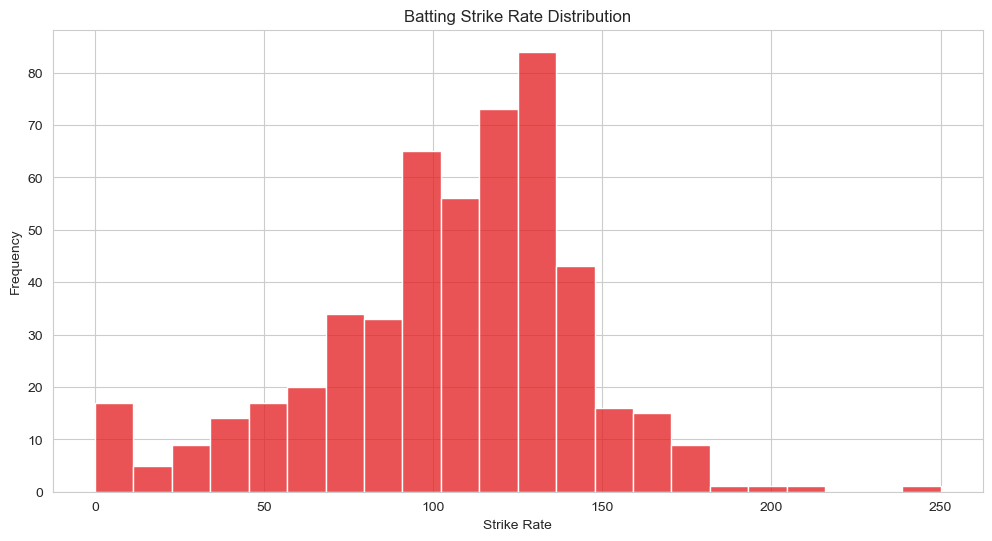

In [16]:
plt.figure(figsize=(12, 6))
sns.histplot(stats['batting SR'].dropna(), color=color_pal[0])
plt.title('Batting Strike Rate Distribution')
plt.xlabel('Strike Rate')
plt.ylabel('Frequency')
plt.show()

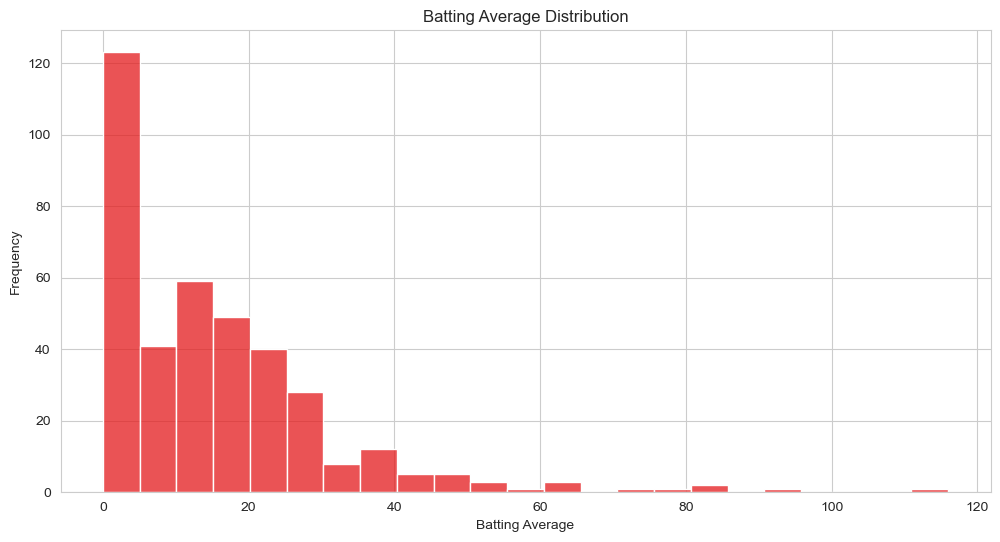

In [104]:
plt.figure(figsize=(12, 6))
sns.histplot(stats['batting average'].dropna(), color=color_pal[0])
plt.title('Batting Average Distribution')
plt.xlabel('Batting Average')
plt.ylabel('Frequency')
plt.show()

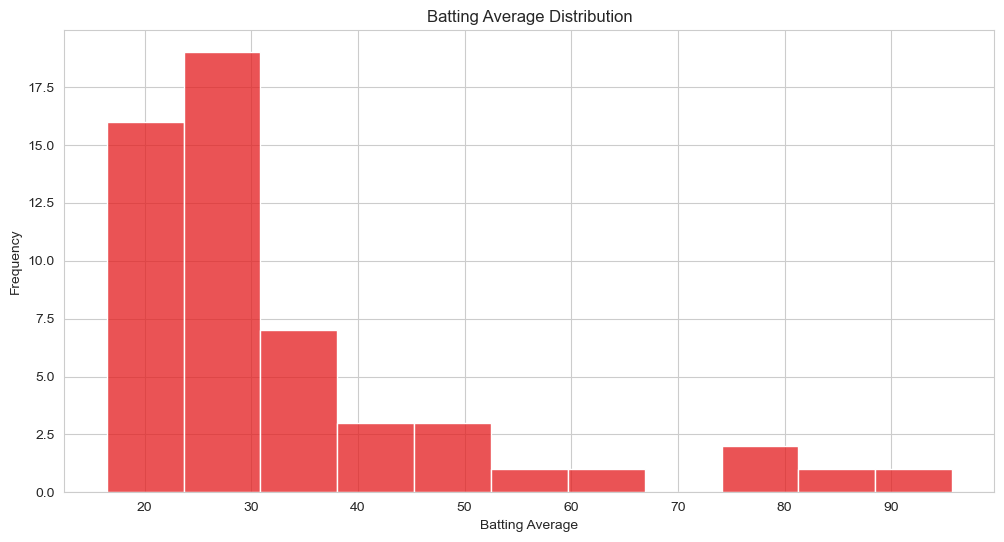

In [105]:
plt.figure(figsize=(12, 6))
sns.histplot(stats.loc[stats['balls'] >= 150, 'batting average'].dropna(), color=color_pal[0])
plt.title('Batting Average Distribution')
plt.xlabel('Batting Average')
plt.ylabel('Frequency')
plt.show()

In [106]:
stats[stats['batting average'] >= 100]

,runs,balls,4s,6s,batting SR,batting average,times dismissed,balls bowled,runs conceded,wickets,economy,bowling average,bowling SR,overs bowled,wides,noballs
player,,,,,,,,,,,,,,,,
Babar Azam,116,89,11,2,130.34,116.0,1,0,0,0,NaN,NaN,NaN,0.0,0,0


Text(0, 0.5, 'Frequency')

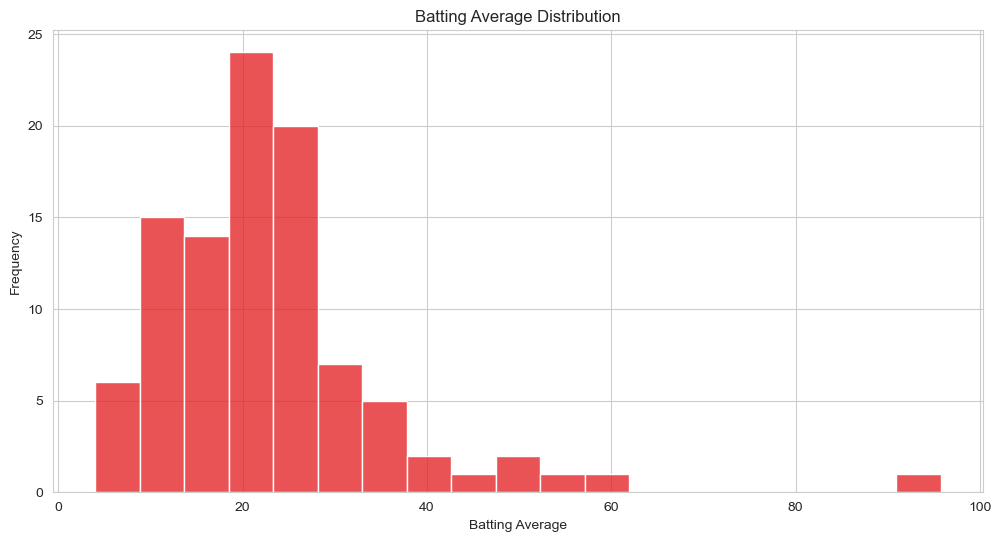

In [107]:
plt.figure(figsize=(12, 6))
sns.histplot(stats.loc[stats['times dismissed'] >= 5, 'batting average'].dropna(), color=color_pal[0])
plt.title('Batting Average Distribution')
plt.xlabel('Batting Average')
plt.ylabel('Frequency')

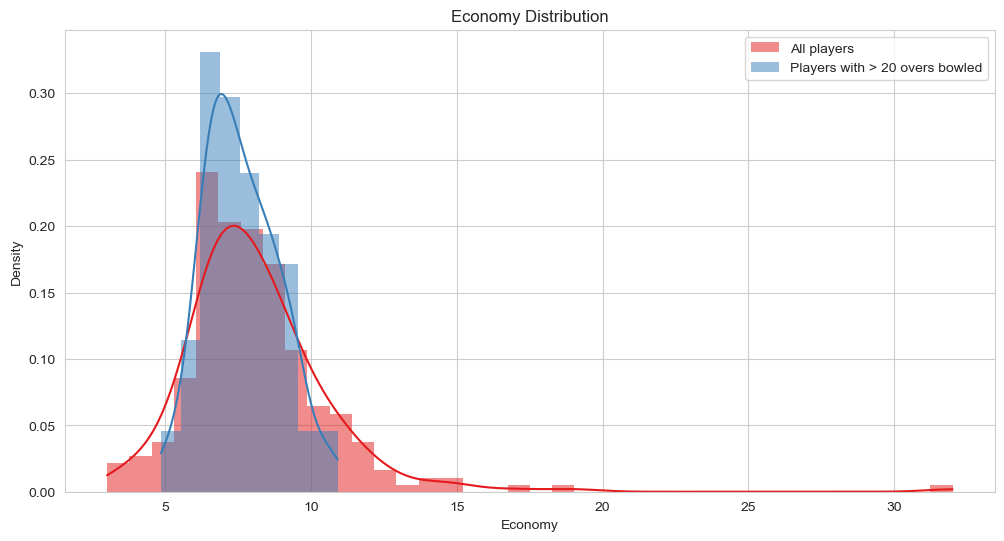

In [108]:
plt.figure(figsize=(12, 6))
sns.histplot(stats['economy'].dropna(), color=color_pal[0], label='All players', linewidth=0, stat='density', kde=True)
sns.histplot(stats.loc[stats['overs bowled'] > 10, 'economy'].dropna(), color=color_pal[1], label='Players with > 20 overs bowled', linewidth=0, stat='density', kde=True)
plt.legend()
plt.title('Economy Distribution')
plt.xlabel('Economy')
plt.ylabel('Density')
plt.show()

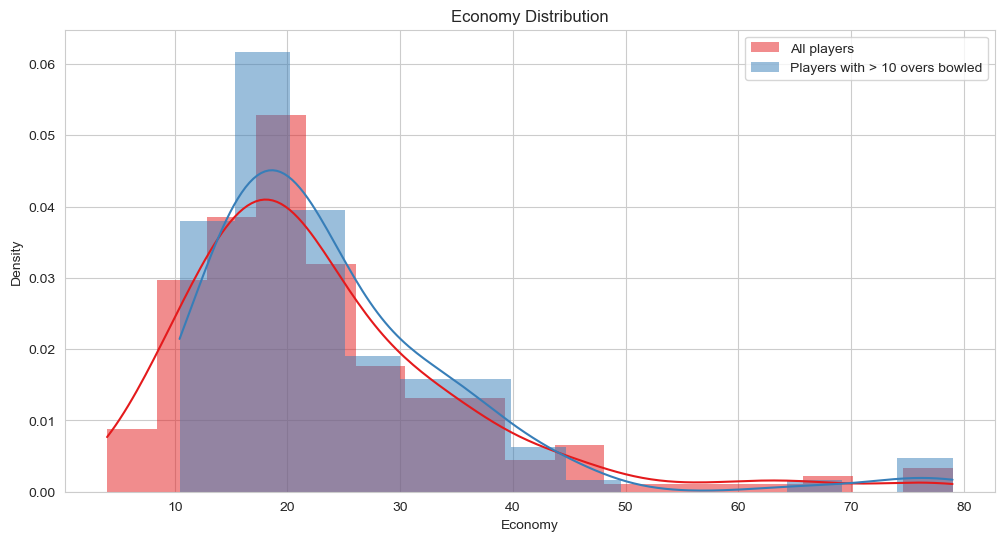

In [109]:
plt.figure(figsize=(12, 6))
sns.histplot(stats['bowling SR'].dropna(), color=color_pal[0], label='All players', linewidth=0, stat='density', kde=True)
sns.histplot(stats.loc[stats['overs bowled'] > 10, 'bowling SR'].dropna(), color=color_pal[1], label='Players with > 10 overs bowled', linewidth=0, stat='density', kde=True)
plt.legend()
plt.title('Economy Distribution')
plt.xlabel('Economy')
plt.ylabel('Density')
plt.show()